In [1]:
import ast
from typing import Annotated, TypedDict
from uuid import uuid4

from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.messages import HumanMessage, AIMessage, ToolCall
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

@tool
def calculator(query: str) -> str:
    '''계산기. 수식만 입력받습니다.'''
    return ast.literal_eval(query)

search = DuckDuckGoSearchRun()
tools = [search, calculator]
model = ChatOpenAI(model="gpt-4o-mini", temperature=0).bind_tools(tools)

class State(TypedDict):
    messages: Annotated[list, add_messages]

def model_node(state: State) -> State:
    res = model.invoke(state['messages'])
    return {'messages': res}

def tools_node(state: State) -> State:
    res = tools.invoke(state['messages'])
    return {'messages': res}

def first_model(state: State) -> State:
    query = state['messages'][-1].content
    search_tool_call = ToolCall(
        name='duckduckgo_search',
        args={'query': query},
        id=uuid4().hex,
    )
    return {
        'messages': AIMessage(content='', tool_calls=[search_tool_call])
    }

builder = StateGraph(State)
builder.add_node('first_model', first_model)
builder.add_node('model', model_node)
builder.add_node('tools', ToolNode(tools))
builder.add_edge(START, 'first_model')
builder.add_edge('first_model', 'tools')
builder.add_conditional_edges('model', tools_condition)
builder.add_edge('tools', 'model')

graph = builder.compile()

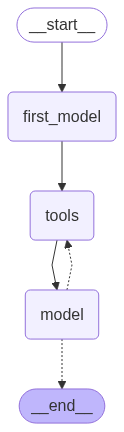

In [2]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
input = {
    'messages': [
        HumanMessage(
            '미국의 제 30대 대통령이 사망했을 때 나이는 몇 살일까요?'
        )
    ]
}

for c in graph.stream(input):
    print(c)

{'first_model': {'messages': AIMessage(content='', additional_kwargs={}, response_metadata={}, id='ecaec3ae-9df7-4956-91ba-c4405be57b44', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': '미국의 제 30대 대통령이 사망했을 때 나이는 몇 살일까요?'}, 'id': 'fc5cfa6257e543a1af5363eca9e2d2cd', 'type': 'tool_call'}])}}


/Users/hippoo/Desktop/SoMA/e-learning/langgraph/.venv/lib/python3.13/site-packages/langchain_community/utilities/duckduckgo_search.py:64: UserWarning: 'api' backend is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


{'tools': {'messages': [ToolMessage(content='존 캘빈 쿨리지 주니어(영어: John Calvin Coolidge, Jr., 1872년 7월 4일 ~ 1933년 1월 5일)는 미국의 30대 대통령이었다. 자신의 과묵한 뉴잉글랜드 태도와 통치에\xa0... 미국의 제30대 대통령. 워런 G. 하딩 행정부에서 제29대 미국 부통령으로 재임하다 하딩 대통령의 급서로 직을 승계해 취임했다. 잠이 많고 말이 없는 특유의 스타일로\xa0... 미국의 제30대 대통령, 잠이 많고 과묵한 스타일로 유명하다. 그 유명한 잠 자다가 대통령이 되는 장면.[2] 고향에서 휴양 중에 하딩의 부고를 듣고 대통령에 취임하는\xa0... 1841년 취임 31일 만에 사망한 윌리엄 헨리 해리슨이 미국 역사상 가장 짧은 대통령 임기를 가졌으며, 프랭클린 D. 루스벨트는 1933년부터 1945년 4번째 임기 초반에 사망\xa0... 2025. 1. 5. ... 존 캘빈 쿨리지 주니어 (John Calvin Coolidge, Jr., 1872년 7월 4일 ~ 1933년 1월 5일)는 미국의 30대 대통령이다. 자신의 과묵한 태도와 통치에 사무\xa0...', name='duckduckgo_search', id='114416e2-c135-40da-90ac-e2abedb2ab97', tool_call_id='fc5cfa6257e543a1af5363eca9e2d2cd')]}}
{'model': {'messages': AIMessage(content='미국의 제 30대 대통령인 존 쿨리지(John Calvin Coolidge)는 1872년 7월 4일에 태어나 1933년 1월 5일에 사망했습니다. 그가 사망했을 때의 나이는 60세입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 64, 'prompt_tokens': 493, 'total_toke